In [1]:
### do our imports
import os,sys
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
import nibabel as nib
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [2]:
#### define nifti data loader class
class NiftisLoader(Dataset):
    """Load a list of registered T1 and T2 volumes"""
    def __init__(self,nifti1,nifti2,transform=None):
        """
        Args:
            nifti1: list of nifti images for first modality
            nifti2: list of nifti images for second modality
            transform: Optional transform to be applied to sample
        """
        ### define the variables from the input here
        self.nifti1=[line.strip() for line in open(nifti1, 'r')]
        self.nifti2=[line.strip() for line in open(nifti2, 'r')]
        self.transform=transform

    def __len__(self):
        return len(self.nifti2)
    
    ### 
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        #### load the niftis
        img1=nib.load(self.nifti1[idx]).get_data().astype(float)
        img2=nib.load(self.nifti2[idx]).get_data().astype(float)

        sample = {'nii1': img1, 'nii2': img2}
        
        if self.transform:
            sample = self.transform(sample)

        return sample
        


In [3]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        img1, img2 = sample['nii1'], sample['nii2']
        return {'nii1': torch.from_numpy(img1),
                'nii2': torch.from_numpy(img2)}

In [51]:
class NiftiSliceLoader(Dataset):
    """Load a list of registered T1 and T2 volumes"""
    def __init__(self,nifti1,nifti2,slices=None,transform=None):
        """
        Args:
            nifti1: list of nifti images for first modality
            nifti2: list of nifti images for second modality
            transform: Optional transform to be applied to sample
        """
        ### define the variables from the input here
        self.nifti1=[line.strip() for line in open(nifti1, 'r')]
        self.nifti2=[line.strip() for line in open(nifti2, 'r')]
        self.slices=slices
        self.transform=transform

    def __len__(self):
        return len(self.nifti2)
    
    ### 
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        #### load the niftis
        img1=nib.load(self.nifti1[idx]).get_data().astype(float)
        img2=nib.load(self.nifti2[idx]).get_data().astype(float)
        
        ##### no slices will load nifti volume for traning
        if self.slices == None:
            sample = {'nii1': img1, 'nii2': img2}
        else:
            ##### select random subset of slices from volume
            dim_lim=min(img1.shape)
            if self.slices > dim_lim:
                sys.exit('Can\'t select more slices than are present in the image')
            else:
                slidx=random.sample(range(dim_lim),self.slices)
                slimg1=[]
                slimg2=[]
                #### each slice is a numpy array stored in a list for each subject
                for i in slidx:
                    ##saggital loop
                    slimg1.append(img1[i,:,:])
                    slimg2.append(img2[i,:,:])
                for i in slidx: 
                    ## coronal loop
                    slimg1.append(img1[:,i,:])
                    slimg2.append(img2[:,i,:])
                for i in slidx:
                    ## axial loop
                    slimg1.append(img1[:,:,i])
                    slimg2.append(img2[:,:,i])
            sample = {'nii1': slimg1, 'nii2': slimg2}
                
        if self.transform:
            sample = self.transform(sample)

        return sample
        



In [55]:
slice_dataset = NiftiSliceLoader(nifti1='T1s.txt',nifti2='T2s.txt',slices=150)

In [56]:
# slice_dataset[50]['nii1'][0].shape

0 450 450
1 450 450
2 450 450
3 450 450


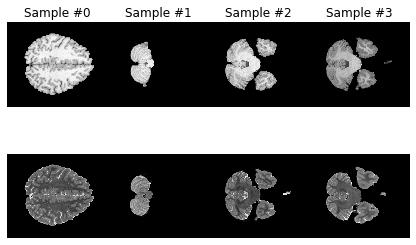

In [59]:
for i in range(len(slice_dataset)):
    sample = slice_dataset[i]
    
    print(i, len(sample['nii1']), len(sample['nii2']))
    ax1 = plt.subplot(2, 4, i + 1)
    plt.tight_layout()
    ax1.set_title('Sample #{}'.format(i))
    ax1.axis('off')
    plt.imshow(sample['nii1'][301],cmap='Greys_r')
    ax1 = plt.subplot(2, 4, i + 5)
    ax1.axis('off')
    plt.imshow(sample['nii2'][301],cmap='Greys_r')
    plt.subplots_adjust(wspace=0, hspace=0)
    
    if i == 3:
        plt.show()
        break

In [7]:
slice_dataset = NiftiSliceLoader(nifti1='T1s.txt',nifti2='T2s.txt')

0 (260, 311, 260) (260, 311, 260)
1 (260, 311, 260) (260, 311, 260)
2 (260, 311, 260) (260, 311, 260)
3 (260, 311, 260) (260, 311, 260)


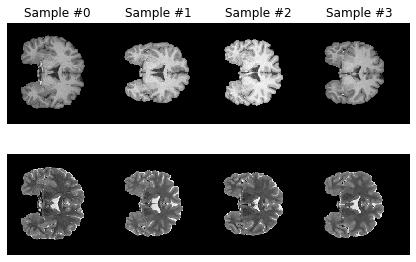

In [8]:
for i in range(len(slice_dataset)):
    sample = slice_dataset[i]
    
    print(i, sample['nii1'].shape, sample['nii2'].shape)
    ax1 = plt.subplot(2, 4, i + 1)
    plt.tight_layout()
    ax1.set_title('Sample #{}'.format(i))
    ax1.axis('off')
    plt.imshow(sample['nii1'][:,180,:],cmap='Greys_r')
    ax1 = plt.subplot(2, 4, i + 5)
    ax1.axis('off')
    plt.imshow(sample['nii2'][:,180,:],cmap='Greys_r')
    plt.subplots_adjust(wspace=0, hspace=0)
    
    if i == 3:
        plt.show()
        break



In [ ]:
data_loader = DataLoader(test_dataset, batch_size=10, shuffle=True, num_workers=8)

In [ ]:
transformed_dataset = NiftisLoader(nifti1='T1s.txt',nifti2='T2s.txt',transform=ToTensor())

In [ ]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['nii1'].size(), sample['nii2'].size())

    if i == 3:
        break